<a href="https://colab.research.google.com/github/SunkaraboinaPraveenKumar/Machine_Learning_Projects/blob/main/Langgraph_Agentic_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install langchain_core langchain_groq langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.1/417.1 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: langchain_core
    Found existing installation: langchain-core 0.3.45
    Uninstalling langchain-core-0.3.45:
      Successfully uninstalled langchain-core-0.3.45


In [4]:
from google.colab import userdata
import os
os.environ['GROQ_API_KEY']=userdata.get('groq_api_key')

In [3]:
import time
from langchain_core.messages import AIMessage
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode

In [5]:
EMAILS = [
    # Email 0
    """
    Date: October 15, 2024
    From: Occupational Safety and Health Administration (OSHA)
    To: Blue Ridge Construction, project 111232345 - Downtown Office
    Complex Location: Dallas, TX

    During a recent inspection of your construction site at 123 Main
    Street,
    the following safety violations were identified:

    Lack of fall protection: Workers on scaffolding above 10 feet
    were without required harnesses or other fall protection
    equipment. Unsafe scaffolding setup: Several scaffolding
    structures were noted as
    lacking secure base plates and bracing, creating potential
    collapse risks.
    Inadequate personal protective equipment (PPE): Multiple
    workers were
    found without proper PPE, including hard hats and safety
    glasses.
    Required Corrective Actions:

    Install guardrails and fall arrest systems on all scaffolding
    over 10 feet. Conduct an inspection of all scaffolding
    structures and reinforce unstable sections. Ensure all
    workers on-site are provided
    with necessary PPE and conduct safety training on proper
    usage.
    Deadline for Compliance: All violations must be rectified
    by November 10, 2024. Failure to comply may result in fines
    of up to
    $25,000 per violation.

    Contact: For questions or to confirm compliance, please reach
    out to the
    OSHA regional office at (555) 123-4567 or email
    compliance.osha@osha.gov.
    """,
    # Email 1
    """
    From: debby@stack.com
    Hey Betsy,
    Here's your invoice for $1000 for the cookies you ordered.
    """,
    # Email 2
    """
    From: tdavid@companyxyz.com
    Hi Paul,
    We have an issue with the HVAC system your team installed in
    apartment 1235. We'd like to request maintenance or a refund.
    Thanks,
    Terrance
    """,
    # Email 3
    """
    Date: January 10, 2025
    From: City of Los Angeles Building and Safety Department
    To: West Coast Development, project 345678123 - Sunset Luxury
    Condominiums
    Location: Los Angeles, CA
    Following an inspection of your site at 456 Sunset Boulevard, we have
    identified the following building code violations:
    Electrical Wiring: Exposed wiring was found in the underground parking
    garage, posing a safety hazard. Fire Safety: Insufficient fire
    extinguishers were available across multiple floors of the structure
    under construction.
    Structural Integrity: The temporary support beams in the eastern wing
    do not meet the load-bearing standards specified in local building
    codes.
    Required Corrective Actions:
    Replace or properly secure exposed wiring to meet electrical safety
    standards. Install additional fire extinguishers in compliance with
    fire code requirements. Reinforce or replace temporary support beams
    to ensure structural stability. Deadline for Compliance: Violations
    must be addressed no later than February 5,
    2025. Failure to comply may result in
    a stop-work order and additional fines.
    Contact: For questions or to schedule a re-inspection, please contact
    the Building and Safety Department at
    (555) 456-7890 or email inspections@lacity.gov.
    """,
]

In [6]:
from datetime import datetime, date
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field, computed_field

class NoticeEmailExtract(BaseModel):
    date_of_notice_str: str | None = Field(
        default=None,
        exclude=True,
        repr=False,
        description="""The date of the notice (if any) reformatted
        to match YYYY-mm-dd""",
    )
    entity_name: str | None = Field(
        default=None,
        description="""The name of the entity sending the notice (if present
        in the message)""",
    )
    entity_phone: str | None = Field(
        default=None,
        description="""The phone number of the entity sending the notice
        (if present in the message)""",
    )
    entity_email: str | None = Field(
        default=None,
        description="""The email of the entity sending the notice
        (if present in the message)""",
    )
    project_id: int | None = Field(
        default=None,
        description="""The project ID (if present in the message) -
        must be an integer""",
    )
    site_location: str | None = Field(
        default=None,
        description="""The site location of the project (if present
        in the message). Use the full address if possible.""",
    )
    violation_type: str | None = Field(
        default=None,
        description="""The type of violation (if present in the
        message)""",
    )
    required_changes: str | None = Field(
        default=None,
        description="""The required changes specified by the entity
        (if present in the message)""",
    )
    compliance_deadline_str: str | None = Field(
        default=None,
        exclude=True,
        repr=False,
        description="""The date that the company must comply (if any)
        reformatted to match YYYY-mm-dd""",
    )
    max_potential_fine: float | None = Field(
        default=None,
        description="""The maximum potential fine
        (if any)""",
    )

    @staticmethod
    def _convert_string_to_date(date_str: str | None) -> date | None:
        try:
            return datetime.strptime(date_str, "%Y-%m-%d").date()
        except Exception as e:
            print(e)
            return None

    @computed_field
    @property
    def date_of_notice(self) -> date | None:
        return self._convert_string_to_date(self.date_of_notice_str)

    @computed_field
    @property
    def compliance_deadline(self) -> date | None:
        return self._convert_string_to_date(self.compliance_deadline_str)

In [7]:
info_parse_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            Parse the date of notice, sending entity name, sending entity
            phone, sending entity email, project id, site location,
            violation type, required changes, compliance deadline, and
            maximum potential fine from the message. If any of the fields
            aren't present, don't populate them. Try to cast dates into
            the YYYY-mm-dd format. Don't populate fields if they're not
            present in the message.

            Here's the notice message:

            {message}
            """,
        )
    ]
)

notice_parser_model = ChatGroq(model="llama-3.3-70b-versatile", temperature=0)

NOTICE_PARSER_CHAIN = (
    info_parse_prompt
    | notice_parser_model.with_structured_output(NoticeEmailExtract)
)

In [8]:
info_parse_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            Parse the date of notice, sending entity name, sending entity
            phone, sending entity email, project id, site location,
            violation type, required changes, compliance deadline, and
            maximum potential fine from the message. If any of the fields
            aren't present, don't populate them. Try to cast dates into
            the YYYY-mm-dd format. Don't populate fields if they're not
            present in the message.

            Here's the notice message:

            {message}
            """,
        )
    ]
)

notice_parser_model = ChatGroq(model="llama-3.3-70b-versatile", temperature=0)

NOTICE_PARSER_CHAIN = (
    info_parse_prompt
    | notice_parser_model.with_structured_output(NoticeEmailExtract)
)

In [9]:
NOTICE_PARSER_CHAIN.invoke({"message": EMAILS[0]})

NoticeEmailExtract(entity_name='Occupational Safety and Health Administration (OSHA)', entity_phone='(555) 123-4567', entity_email='compliance.osha@osha.gov', project_id=111232345, site_location='123 Main Street, Dallas, TX', violation_type='Lack of fall protection, Unsafe scaffolding setup, Inadequate personal protective equipment (PPE)', required_changes='Install guardrails and fall arrest systems on all scaffolding over 10 feet. Conduct an inspection of all scaffolding structures and reinforce unstable sections. Ensure all workers on-site are provided with necessary PPE and conduct safety training on proper usage.', max_potential_fine=25000.0, date_of_notice=datetime.date(2024, 10, 15), compliance_deadline=datetime.date(2024, 11, 10))

In [11]:
from typing import TypedDict
from langgraph.graph import END, START, StateGraph
from pydantic import EmailStr

In [12]:
import logging

logging.getLogger("httpx").setLevel(logging.WARNING)
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
LOGGER = logging.getLogger(__name__)

In [17]:
class GraphState(TypedDict):
    notice_message: str
    notice_email_extract: NoticeEmailExtract | None
    escalation_text_criteria: str
    escalation_dollar_criteria: float
    requires_escalation: bool
    escalation_emails: list[EmailStr] | None
    follow_ups: dict[str, bool] | None
    current_follow_up: str | None

workflow = StateGraph(GraphState)

In [18]:
def parse_notice_message_node(state:GraphState)->GraphState:
    """Use the notice parser chain to extract fields from the notice"""
    notice_email_extract = NOTICE_PARSER_CHAIN.invoke(
        {"message": state["notice_message"]}
    )
    state["notice_email_extract"] = notice_email_extract
    return state

In [19]:
def check_escalation_status_node(state: GraphState) -> GraphState:
    """Determine whether a notice needs escalation"""
    text_check = ESCALATION_CHECK_CHAIN.invoke(
        {
            "escalation_criteria": state["escalation_text_criteria"],
            "message": state["notice_message"],
        }
    ).needs_escalation

    if (
        text_check
        or state["notice_email_extract"].max_potential_fine
        >= state["escalation_dollar_criteria"]
    ):
        state["requires_escalation"] = True
    else:
        state["requires_escalation"] = False

    return state

workflow.add_node("parse_notice_message", parse_notice_message_node)
workflow.add_node("check_escalation_status", check_escalation_status_node)

In [20]:
!pip install pydantic[email]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 11.2 MB/s eta 0:00:00


In [21]:
# ...

workflow.add_edge(START, "parse_notice_message")
workflow.add_edge("parse_notice_message", "check_escalation_status")
workflow.add_edge("check_escalation_status", END)

NOTICE_EXTRACTION_GRAPH = workflow.compile()

In [22]:
# ...

@tool
def forward_email(email_message: str, send_to_email: str) -> bool:
    """
    Forward an email_message to the address of send_to_email. Returns
    true if the email was successful otherwise it wil return false. Note
    that this tool only forwards the email to an internal department -
    it does not reply to the sender.
    """
    LOGGER.info(f"Forwarding the email to {send_to_email}...")
    time.sleep(2)
    LOGGER.info("Email forwarded!")
    return True

@tool
def send_wrong_email_notification_to_sender(
    sender_email: str, correct_department: str
):
    """
    Send an email back to the sender informing them that
    they have the wrong address. The email should be sent
    to the correct_department.
    """
    LOGGER.info(f"Sending wrong email notification to {sender_email}...")
    time.sleep(2)
    LOGGER.info("Email sent!")
    return True

@tool
def extract_notice_data(
    email: str, escalation_criteria: str
) -> NoticeEmailExtract:
    """
    Extract structured fields from a regulatory notice.
    This should be used when the email message comes from
    a regulatory body or auditor regarding a property or
    construction site that the company works on.

    escalation_criteria is a description of which kinds of
    notices require immediate escalation.

    After calling this tool, you don't need to call any others.
    """
    LOGGER.info("Calling the email notice extraction graph...")
    initial_state = {
        "notice_message": email,
        "notice_email_extract": None,
        "critical_fields_missing": False,
        "escalation_text_criteria": escalation_criteria,
        "escalation_dollar_criteria": 100_000,
        "requires_escalation": False,
        "escalation_emails": ["brog@abc.com", "bigceo@company.com"],
    }

    results = NOTICE_EXTRACTION_GRAPH.invoke(initial_state)
    return results["notice_email_extract"]

@tool
def determine_email_action(email: str) -> str:
    """
    Call to determine which action should be taken
    for an email. Only use when the other tools don't seem
    relevant for the email task. Do not call this tool if
    you've already called extract_notice_data.
    """
    return """
    If the email appears to be an invoice of any kind or related to
    billing, forward the email to the billing and invoices team:
    billing@company.com and send a wrong email notice back to the
    sender. The correct department is billing@company.com.

    If the email appears to be from a customer, forward to
    support@company.com, cdetuma@company.com, and ctu@abc.com.
    Be sure to forward it to all three emails listed.
    Send a wrong email notice back to the
    customer and let them know the correct department is
    support@company.com.

    For any other emails, please send a wrong email notification
    and try to infer the correct department from one of
    billing@company.com, support@company.com,
    humanresources@company.com, and it@company.com.
    """

In [24]:
# ...

tools = [
    determine_email_action,
    forward_email,
    send_wrong_email_notification_to_sender,
    extract_notice_data,
]
tool_node = ToolNode(tools)
EMAIL_AGENT_MODEL = ChatGroq(model="llama-3.3-70b-versatile",temperature=0).bind_tools(
    tools
)

def call_agent_model_node(state: MessagesState) -> dict[str, list[AIMessage]]:
    """Node to call the email agent model"""
    messages = state["messages"]
    response = EMAIL_AGENT_MODEL.invoke(messages)
    return {"messages": [response]}

def route_agent_graph_edge(state: MessagesState) -> str:
    """Determine whether to call more tools or exit the graph"""
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "email_tools"
    return END

In [25]:
workflow = StateGraph(MessagesState)

workflow.add_node("email_agent", call_agent_model_node)
workflow.add_node("email_tools", tool_node)

workflow.add_edge(START, "email_agent")
workflow.add_conditional_edges(
    "email_agent", route_agent_graph_edge, ["email_tools", END]
)
workflow.add_edge("email_tools", "email_agent")

email_agent_graph = workflow.compile()

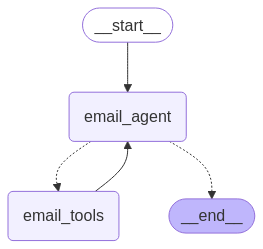

In [26]:
email_agent_graph

In [27]:
message_1 = {"messages": [("human", EMAILS[1])]}

In [28]:
for chunk in email_agent_graph.stream(message_1, stream_mode="values"):
  chunk["messages"][-1].pretty_print()

================================ Human Message =================================


    From: debby@stack.com
    Hey Betsy,
    Here's your invoice for $1000 for the cookies you ordered.
    
================================== Ai Message ==================================
Tool Calls:
  determine_email_action (call_1z63)
 Call ID: call_1z63
  Args:
    email: From: debby@stack.com Hey Betsy, Here's your invoice for $1000 for the cookies you ordered.
================================= Tool Message =================================
Name: determine_email_action


    If the email appears to be an invoice of any kind or related to
    billing, forward the email to the billing and invoices team:
    billing@company.com and send a wrong email notice back to the
    sender. The correct department is billing@company.com.

    If the email appears to be from a customer, forward to
    support@company.com, cdetuma@company.com, and ctu@abc.com.
    Be sure to forward it to all three emails listed.


In [30]:
message_2 = {"messages": [("human", EMAILS[2])]}

In [31]:
for chunk in email_agent_graph.stream(message_2, stream_mode="values"):
      chunk["messages"][-1].pretty_print()

================================ Human Message =================================


    From: tdavid@companyxyz.com
    Hi Paul,
    We have an issue with the HVAC system your team installed in
    apartment 1235. We'd like to request maintenance or a refund.
    Thanks,
    Terrance
    
================================== Ai Message ==================================
Tool Calls:
  determine_email_action (call_k296)
 Call ID: call_k296
  Args:
    email: From: tdavid@companyxyz.com Hi Paul, We have an issue with the HVAC system your team installed in apartment 1235. We'd like to request maintenance or a refund. Thanks, Terrance
================================= Tool Message =================================
Name: determine_email_action


    If the email appears to be an invoice of any kind or related to
    billing, forward the email to the billing and invoices team:
    billing@company.com and send a wrong email notice back to the
    sender. The correct department is billing@company.

In [32]:
escalation_criteria = """"There's an immediate risk of electrical,
water, or fire damage"""

message_with_criteria = f"""
The escalation criteria is: {escalation_criteria}

Here's the email:

{EMAILS[3]}
"""
message_3 = {"messages": [("human", message_with_criteria)]}

for chunk in email_agent_graph.stream(message_3, stream_mode="values"):
     chunk["messages"][-1].pretty_print()

================================ Human Message =================================


The escalation criteria is: "There's an immediate risk of electrical,
water, or fire damage

Here's the email:


    Date: January 10, 2025
    From: City of Los Angeles Building and Safety Department
    To: West Coast Development, project 345678123 - Sunset Luxury
    Condominiums
    Location: Los Angeles, CA
    Following an inspection of your site at 456 Sunset Boulevard, we have
    identified the following building code violations:
    Electrical Wiring: Exposed wiring was found in the underground parking
    garage, posing a safety hazard. Fire Safety: Insufficient fire
    extinguishers were available across multiple floors of the structure
    under construction.
    Structural Integrity: The temporary support beams in the eastern wing
    do not meet the load-bearing standards specified in local building
    codes.
    Required Corrective Actions:
    Replace or properly secure exposed wiring 

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [33]:
escalation_criteria = """"There's an immediate risk of electrical, water, or fire damage"""

In [34]:
message_with_criteria = f"""
... The escalation criteria is: {escalation_criteria}
...
... Here's the email:
...
... {EMAILS[3]}
"""

In [35]:
message_3 = {"messages": [("human", message_with_criteria)]}


In [ ]:
for chunk in email_agent_graph.stream(message_3, stream_mode="values"):
     chunk["messages"][-1].pretty_print()

================================ Human Message =================================


The escalation criteria is: "There's an immediate risk of electrical, water, or fire damage

Here's the email:


    Date: January 10, 2025
    From: City of Los Angeles Building and Safety Department
    To: West Coast Development, project 345678123 - Sunset Luxury
    Condominiums
    Location: Los Angeles, CA
    Following an inspection of your site at 456 Sunset Boulevard, we have
    identified the following building code violations:
    Electrical Wiring: Exposed wiring was found in the underground parking
    garage, posing a safety hazard. Fire Safety: Insufficient fire
    extinguishers were available across multiple floors of the structure
    under construction.
    Structural Integrity: The temporary support beams in the eastern wing
    do not meet the load-bearing standards specified in local building
    codes.
    Required Corrective Actions:
    Replace or properly secure exposed wiring 